In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using LimberJack
using GaussianProcess

┌ Info: Precompiling GaussianProcess [03743745-d558-4e78-88be-b659dc33ea21]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally bro

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

In [2]:
# Squared-exponential covariance function
function sqexp_cov_fn2(X, eta, l)
    D = pairwise(Distances.Euclidean(), X, dims=1)
    return @.(eta * exp(-D^2 / (2*l))) + 0.0005 * LinearAlgebra.I
end 

# Exponential covariance function
function exp_cov_fn2(X, eta, l)
    D = pairwise(Distances.Euclidean(), X, dims=1)
    return   @.(eta * exp(-D / l)) + 0.0005 * LinearAlgebra.I
end

exp_cov_fn2 (generic function with 1 method)

In [3]:
@model function marginal_GP(y, X; data_cov=data_cov, cosmology=Cosmology())
    # Priors.
    eta ~ Exponential(1)
    l ~ Uniform(0.01, 3)
    
    # Realized covariance function
    K = sqexp_cov_fn(X, eta, l) 
    mean = cosmology.Dz(vec(X))
    y ~ marginal_lkl(mean, K; data_cov=data_cov)
end

marginal_GP (generic function with 1 method)

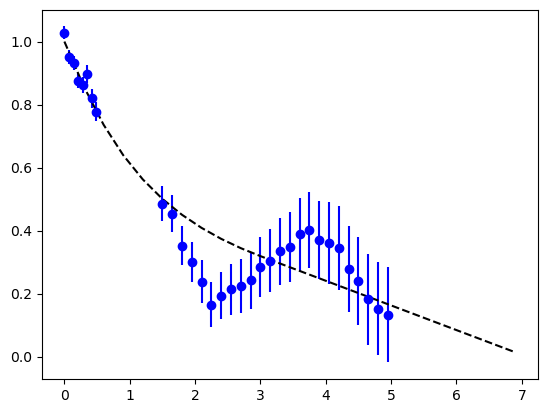

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7ffbdbe4d250>

In [4]:
cosmology = Cosmology()
data_1_x = Vector(0:0.07:0.5)
data_2_x = Vector(1.5:0.15:5)
data_x = zeros(length(data_1_x)+length(data_2_x), 1)
data_x[1:length(data_1_x), 1] = data_1_x
data_x[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = data_2_x
N = length(data_x)

data = similar(vec(data_x))
data[1:length(data_1_x), 1] = cosmology.Dz(vec(data_1_x)) .* (1 .+ randn(length(data_1_x)) .* 0.03)
data[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = cosmology.Dz(vec(data_2_x)) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))
#data = cosmology.Dz(vec(data_x)) .* (1 .+ 0.5 .* (sin.(vec(data_x)./0.5) + randn(N) * 0.1))
data_err = vec(@.((0.02 * data) + (0.03 * vec(data_x))))
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo")
gp_x = Vector(0:0.3:7)
gp_N = length(gp_x)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "k--")

In [5]:
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

In [6]:
chain = sample(marginal_GP(data, data_x), HMC(0.01, 100), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16


Chains MCMC chain (1000×11×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = eta, l
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

         eta    0.0582    0.0959     0.0030    0.0098   151.9669    1.0008
           l    1.1618    0.7118     0.0225    0.0984    50.5360    1.0152

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         eta    0.0036    0.0113    0.0246    0.0627    0.3392
           l    0.2174    0.6130    0.9917    1.5608    2.8445


┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364


In [7]:
etas = group(chain, :eta).value.data[:, :, 1]
ls = group(chain, :l).value.data[:, :, 1];

In [9]:
mean_old = cosmology.Dz(vec(data_x))
mean_new = cosmology.Dz(vec(gp_x))

gp_predict = posterior_predict(gp_x, data_x, mean_new, mean_old, data,
                                sqexp_cov_fn; data_cov=data_cov)
ynew = [gp_predict(eta=etas[m], l=ls[m]) for m in 1:length(etas)]
ynew = hcat(ynew...);

In [10]:
pred_mean = mean(ynew, dims=2)
pred_std = std(ynew, dims=2);

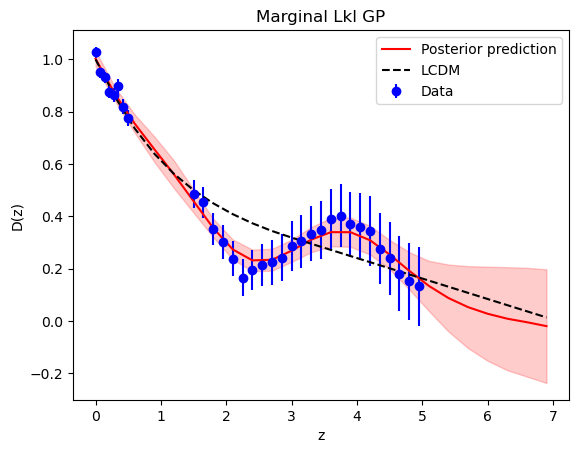

In [11]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(gp_x), vec(pred_mean), color="red",
         label="Posterior prediction")
plt.fill_between(vec(gp_x), vec(pred_mean .+ pred_std),
                 vec(pred_mean .- pred_std), color="red",
                 alpha=0.2)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "k--", label="LCDM")
plt.xlabel("z")
plt.ylabel("D(z)")
plt.title("Marginal Lkl GP")
plt.legend()
#plt.legend(loc="lower right")
#plt.title("GP Posterior predictive with 95% credible interval");